In [1]:
!pip install numpy pandas scikit-learn matplotlib seaborn pywt torch openpyxl

ERROR: Could not find a version that satisfies the requirement pywt (from versions: none)
ERROR: No matching distribution found for pywt


In [2]:
!pip install torch

In [3]:
!pip install openpyxl

In [4]:
!pip install PyWavelets


Reading sheet: Week 15, Apr 2019
Reading sheet: Week 21, May 2019
Reading sheet: Week 24, Jun 2019
Reading sheet: Week 29, Jul 2019
Reading sheet: Week 33, Aug 2019
Reading sheet: Week 37, Sep 2019
Reading sheet: Week 41, Oct 2019
Reading sheet: Week 44, Nov 2019
Reading sheet: Week 51, Dec 2019
Reading sheet: Week 01, Jan 2020
Reading sheet: Week 06, Feb 2020
Reading sheet: Week 10, Mar 2020
Reading sheet: Week 20, May 2020
Reading sheet: Week 24, Jun 2020

Combined data shape: (2352, 11)

===== Final Overall Results =====

      Model          MSE       RMSE      MAPE
0      LSTM  5266.647949  72.571675  4.844528
1  DWT-LSTM  4853.654785  69.668176  4.652342
2      NARX  3981.850342  63.101904  4.250521
3       SVM  2990.551643  54.685936  3.833378


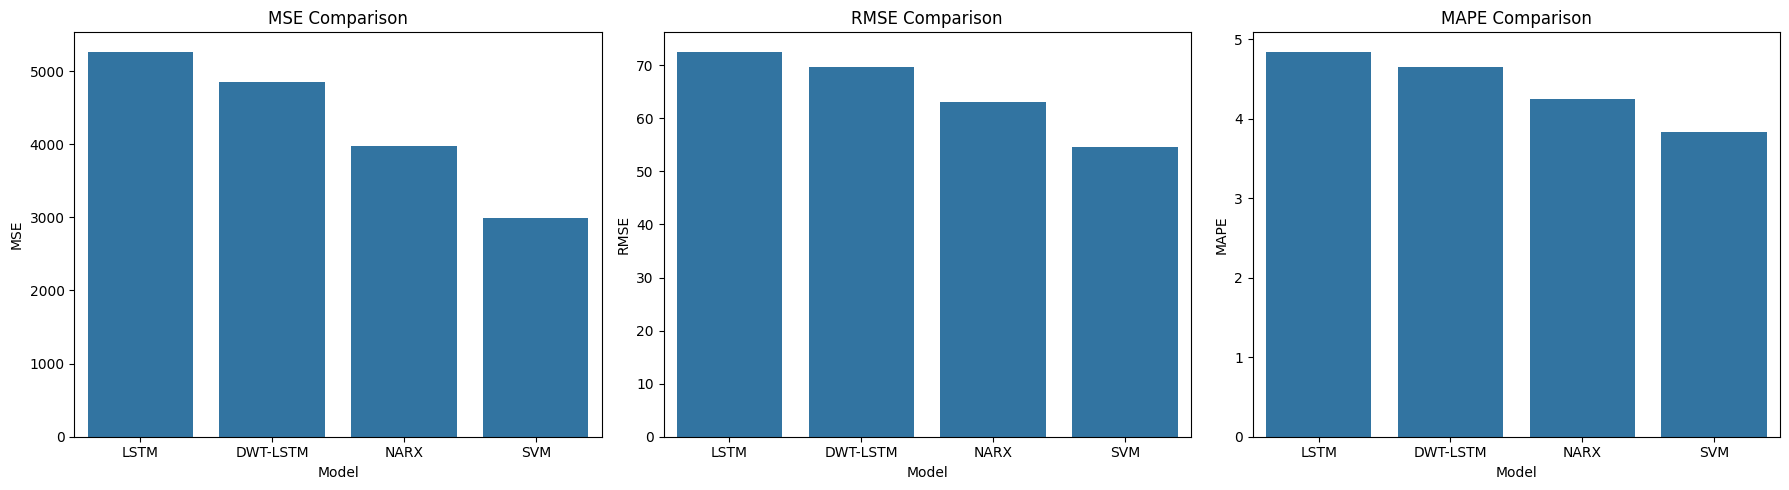

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pywt
import torch
import torch.nn as nn
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Define Models
class LSTMNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMNet, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.unsqueeze(1)
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

class NARXNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NARXNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

# Helper functions
def train_model(model, X_train, y_train, epochs=100, lr=0.001):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    for _ in range(epochs):
        model.train()
        optimizer.zero_grad()
        output = model(X_train)
        loss = criterion(output, y_train)
        loss.backward()
        optimizer.step()
    return model

def evaluate_model(model, X_test, y_test, scaler_y):
    model.eval()
    with torch.no_grad():
        preds = model(X_test).numpy()
    preds_rescaled = scaler_y.inverse_transform(preds)
    y_test_rescaled = scaler_y.inverse_transform(y_test.numpy())
    mse = mean_squared_error(y_test_rescaled, preds_rescaled)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_test_rescaled - preds_rescaled) / y_test_rescaled)) * 100
    return mse, rmse, mape

def apply_dwt(X):
    return np.array([np.concatenate(pywt.dwt(row, 'haar'), axis=0) for row in X])

# Read and combine all sheets
excel_path = 'test_dataframes.xlsx'
xls = pd.ExcelFile(excel_path)

combined_data = []

for sheet in xls.sheet_names:
    print(f"Reading sheet: {sheet}")
    data = xls.parse(sheet)
    data = data.select_dtypes(include=[np.number])  # Only numeric columns
    if data.shape[1] < 2:
        print(f"Skipping sheet {sheet} due to insufficient numeric data.")
        continue
    combined_data.append(data)

# Combine all sheets
full_data = pd.concat(combined_data, axis=0).reset_index(drop=True)
print("\nCombined data shape:", full_data.shape)

# Features and target
X = full_data.iloc[:, :-1].values
y = full_data.iloc[:, -1].values

# Scaling
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Convert to tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32)

input_size = X_train.shape[1]
hidden_size = 64
output_size = 1

# ===== LSTM Model =====
lstm_model = LSTMNet(input_size, hidden_size, output_size)
lstm_model = train_model(lstm_model, X_train_t, y_train_t, epochs=200)
lstm_mse, lstm_rmse, lstm_mape = evaluate_model(lstm_model, X_test_t, y_test_t, scaler_y)

# ===== DWT-LSTM Model =====
X_train_dwt = apply_dwt(X_train)
X_test_dwt = apply_dwt(X_test)
X_train_dwt_t = torch.tensor(X_train_dwt, dtype=torch.float32)
X_test_dwt_t = torch.tensor(X_test_dwt, dtype=torch.float32)

dwt_lstm_model = LSTMNet(X_train_dwt.shape[1], hidden_size, output_size)
dwt_lstm_model = train_model(dwt_lstm_model, X_train_dwt_t, y_train_t, epochs=200)
dwt_lstm_mse, dwt_lstm_rmse, dwt_lstm_mape = evaluate_model(dwt_lstm_model, X_test_dwt_t, y_test_t, scaler_y)

# ===== NARX Model =====
narx_model = NARXNet(input_size, hidden_size, output_size)
narx_model = train_model(narx_model, X_train_t, y_train_t, epochs=200)
narx_mse, narx_rmse, narx_mape = evaluate_model(narx_model, X_test_t, y_test_t, scaler_y)

# ===== SVM Model =====
svm_model = SVR()
svm_model.fit(X_train, y_train.ravel())
svm_preds = svm_model.predict(X_test)
svm_preds_rescaled = scaler_y.inverse_transform(svm_preds.reshape(-1, 1))
y_test_rescaled = scaler_y.inverse_transform(y_test)
svm_mse = mean_squared_error(y_test_rescaled, svm_preds_rescaled)
svm_rmse = np.sqrt(svm_mse)
svm_mape = np.mean(np.abs((y_test_rescaled - svm_preds_rescaled) / y_test_rescaled)) * 100

# ===== Collect Results =====
results = {
    'Model': ['LSTM', 'DWT-LSTM', 'NARX', 'SVM'],
    'MSE': [lstm_mse, dwt_lstm_mse, narx_mse, svm_mse],
    'RMSE': [lstm_rmse, dwt_lstm_rmse, narx_rmse, svm_rmse],
    'MAPE': [lstm_mape, dwt_lstm_mape, narx_mape, svm_mape]
}

results_df = pd.DataFrame(results)

# ===== Display Final Results =====
print("\n===== Final Overall Results =====\n")
print(results_df)

# ===== Plotting Results =====
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
sns.barplot(x='Model', y='MSE', data=results_df)
plt.title('MSE Comparison')

plt.subplot(1, 3, 2)
sns.barplot(x='Model', y='RMSE', data=results_df)
plt.title('RMSE Comparison')

plt.subplot(1, 3, 3)
sns.barplot(x='Model', y='MAPE', data=results_df)
plt.title('MAPE Comparison')

plt.tight_layout()
plt.show()
